<a href="https://colab.research.google.com/github/DuckShyamalan/COMP6248-Reproducibility-Challenge/blob/main/Distortions_and_FGSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

     |████████████████████████████████| 143kB 26.8MB/s 


In [2]:
import torch
import torchbearer
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

In [5]:
#403 fix
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [6]:
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

trainset.data = trainset.data[0:27105]
trainset.targets = trainset.targets[0:27105]

# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Models

In [7]:
#Baseline
class BaselineModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(BaselineModel, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size) 
    self.fc2 = nn.Linear(hidden_size, hidden_size) 
    self.fc3 = nn.Linear(hidden_size, num_classes)  
    
  def forward(self, x):
      out = self.fc1(x)
      out = F.relu(out)
      out = F.dropout(out, 0.2)        
      out = self.fc2(out)        
      out = F.relu(out)
      out = self.fc3(out)
      if not self.training:
          out = F.softmax(out, dim=1)
      return out

#Defensive Distillation
class DistillationNetwork(nn.Module):
  def __init__(self):
    super(DistillationNetwork, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, (5, 5), padding=0)
    self.conv2 = nn.Conv2d(32, 64, (3, 3), padding=0)
    self.fc1 = nn.Linear(64 * 5**2, 1200)
    self.fc2 = nn.Linear(1200, 10)

  def forward(self, x):
    x = torch.reshape(x, [-1, 1,28,28])  #need x to be a 4-d input instead of 2-d
    out = self.conv1(x)
    out = F.relu(out)
    out = F.max_pool2d(out, (2,2))
    out = self.conv2(out)
    out = F.relu(out)
    out = F.max_pool2d(out, (2,2))
    out = F.dropout(out, 0.2)
    out = out.view(out.shape[0], -1)
    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    if not self.training:
      out = F.softmax(out/50, dim=1)  #authors used T=50
    return out

#Fine-tuning
class FineTuneModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(FineTuneModel, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size) 
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    out = self.fc1(x)
    out = F.relu(out)
    out = F.dropout(out, 0.2)
    out = self.fc2(out)
    out = F.relu(out)
    out = self.fc3(out)
    if not self.training:
      out = F.softmax(out, dim=1)
    return out

#Control ANN?
'''TODO: 
check fine-tuning learning rate; 
crosscheck if controlANN is required considering it seems to be the same as FineTuneModel
''' 


'TODO: \ncheck fine-tuning learning rate; \ncrosscheck if controlANN is required considering it seems to be the same as FineTuneModel\n'

In [8]:
#Fast Gradient Sign Method (FGSM) for generating adversarial images
def fgsm(model, lossfn, images, labels, eps):
  #x′ = x + εsign(∇xJ(θ,x,y))
  
  images = images.to(device)
  labels = labels.to(device)
  images.requires_grad = True

  outputs = model(images)
  model.zero_grad() #no optimiser

  # forward + loss + backward + optimise (update weights)
  loss = lossfn(outputs, labels).to(device)
  loss.backward()

  atk = torch.clamp(images + eps*images.grad.sign(), 0,1) #min value 0; max 1
  return atk

# **Blur**

In [15]:
blur_sigma = [0, 0.5, 1.0, 1.5, 2.0, 2.5]

#lists containing test accuracies
blur_control = []
blur_sleep = []
blur_ftblur = []
blur_ftnoise = []
blur_defdist = []

In [16]:
for s in blur_sigma:
  #blur data
  trainset = MNIST(".", train=True, download=True, transform=transform)
  testset = MNIST(".", train=False, download=True, transform=transform)

  trainset.data = trainset.data[0:27105]
  trainset.targets = trainset.targets[0:27105]

  trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
  testloader = DataLoader(testset, batch_size=128, shuffle=True)

  #distorting the testset
  for i in range(0, len(testset)):
    img = testset.test_data[i].numpy()
    blurred_img = gaussian_filter(img, sigma=s)
    testset.test_data[i] = torch.from_numpy(blurred_img)

  trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
  testloader = DataLoader(testset, batch_size=128, shuffle=True)


  #test the control network
  #model = torch.load('save_ann.pkl')  #baseline ann
  model = BaselineModel(784, 1200, 10)
  model.load_state_dict(torch.load("Models/fine_tune.pt"))  #baseline ann
  loss_function = nn.CrossEntropyLoss()
  optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
  trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(trainloader, test_generator=testloader)
  #trial.run(epochs=2)
  results = trial.evaluate(data_key=torchbearer.TEST_DATA)
  blur_control.append(results["test_acc"])

  #test the sleep network
  #model = torch.load('save_sleep.pkl')  #sleep
  model = FineTuneModel(784, 1200, 10)
  #model = BaselineModel(784, 1200, 10)
  model.load_state_dict(torch.load("Models/snn_model.pt"))  #sleep
  W1 = torch.clone(model.fc1.weight.data).to(device)
  W2 = torch.clone(model.fc2.weight.data).to(device)
  W3 = torch.clone(model.fc3.weight.data).to(device)

  model.fc1.weight = torch.nn.Parameter(W1/2.19)
  model.fc2.weight = torch.nn.Parameter(W2/2.19)
  model.fc3.weight = torch.nn.Parameter(W3/2.19)
  loss_function = nn.CrossEntropyLoss()
  optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
  trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(trainloader, test_generator=testloader)
  #trial.run(epochs=2)
  results = trial.evaluate(data_key=torchbearer.TEST_DATA)
  blur_sleep.append(results["test_acc"])

  #test the finetuned network with blur
  #model = torch.load('save_blur.pkl')  #sleep
  model = FineTuneModel(784, 1200, 10)
  model.load_state_dict(torch.load("Models/blur_model.pt"))  #sleep
  loss_function = nn.CrossEntropyLoss()
  optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
  trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(trainloader, test_generator=testloader)
  #trial.run(epochs=2)
  results = trial.evaluate(data_key=torchbearer.TEST_DATA)
  blur_ftblur.append(results["test_acc"])

  #test the finetuned network with noise
  #model = torch.load('save_blur.pkl')  #sleep
  model = FineTuneModel(784, 1200, 10)
  model.load_state_dict(torch.load("Models/noise_model.pt"))  #sleep
  loss_function = nn.CrossEntropyLoss()
  optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
  trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(trainloader, test_generator=testloader)
  #trial.run(epochs=2)
  results = trial.evaluate(data_key=torchbearer.TEST_DATA)
  blur_ftnoise.append(results["test_acc"])

  #test the defensive distillation network
  model = DistillationNetwork()
  model.load_state_dict(torch.load("Models/def_distil_model.pt"))
  loss_function = nn.CrossEntropyLoss()
  optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
  trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(trainloader, test_generator=testloader)
  #trial.run(epochs=2)
  results = trial.evaluate(data_key=torchbearer.TEST_DATA)
  blur_defdist.append(results["test_acc"])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


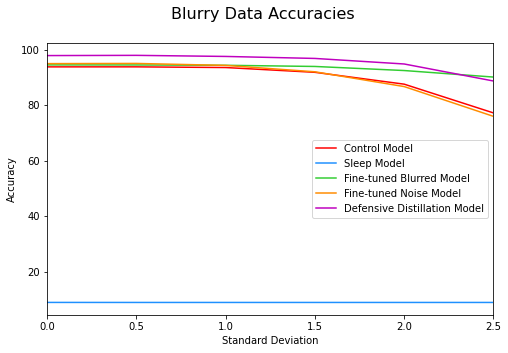

In [17]:
fig = plt.figure(figsize=(8,5))
fig.suptitle('Blurry Data Accuracies', fontsize=16)
ax = fig.add_subplot(111)
ax.plot(blur_sigma, [i*100 for i in blur_control], color="red", label="Control Model")
ax.plot(blur_sigma,[i*100 for i in blur_sleep], color='dodgerblue', label="Sleep Model")
ax.plot(blur_sigma,[i*100 for i in blur_ftblur], color="limegreen", label="Fine-tuned Blurred Model")
ax.plot(blur_sigma,[i*100 for i in blur_ftnoise], color="darkorange", label="Fine-tuned Noise Model")
ax.plot(blur_sigma,[i*100 for i in blur_defdist], color='m', label="Defensive Distillation Model")
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Accuracy")
ax.set_xlim(xmin=0.0, xmax=2.5)
#ax.legend(loc="upper right", bbox_to_anchor=(1.4, 1))
ax.legend()

# **Noise**

In [25]:
noise_variance = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

#lists containing test accuracies
noise_control = []
noise_sleep = []
noise_ftblur = []
noise_ftnoise = []
noise_defdist = []

In [26]:
for v in noise_variance:
  #add noise to data
  trainset = MNIST(".", train=True, download=True, transform=transform)
  testset = MNIST(".", train=False, download=True, transform=transform)

  trainset.data = trainset.data[0:27105]
  trainset.targets = trainset.targets[0:27105]

  trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
  testloader = DataLoader(testset, batch_size=128, shuffle=True)

  #distorting the testset
  for i in range(0, len(testset)):
    img = testset.test_data[i].numpy()
    noise = np.random.normal(0, np.sqrt(v), img.shape)
    noisy_img = img + noise
    testset.test_data[i] = torch.from_numpy(noisy_img)

  trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
  testloader = DataLoader(testset, batch_size=128, shuffle=True)


  #test the control network
  #model = torch.load('save_ann.pkl')  #baseline ann
  model = BaselineModel(784, 1200, 10)
  model.load_state_dict(torch.load("Models/fine_tune.pt"))  #baseline ann
  loss_function = nn.CrossEntropyLoss()
  optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
  trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(trainloader, test_generator=testloader)
  #trial.run(epochs=2)
  results = trial.evaluate(data_key=torchbearer.TEST_DATA)
  noise_control.append(results["test_acc"])

  #test the sleep network
  #model = torch.load('save_sleep.pkl')  #sleep
  model = FineTuneModel(784, 1200, 10)
  #model = BaselineModel(784, 1200, 10)
  model.load_state_dict(torch.load("Models/snn_model.pt"))  #sleep
  W1 = torch.clone(model.fc1.weight.data).to(device)
  W2 = torch.clone(model.fc2.weight.data).to(device)
  W3 = torch.clone(model.fc3.weight.data).to(device)

  model.fc1.weight = torch.nn.Parameter(W1/2.19)
  model.fc2.weight = torch.nn.Parameter(W2/2.19)
  model.fc3.weight = torch.nn.Parameter(W3/2.19)
  loss_function = nn.CrossEntropyLoss()
  optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
  trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(trainloader, test_generator=testloader)
  #trial.run(epochs=2)
  results = trial.evaluate(data_key=torchbearer.TEST_DATA)
  noise_sleep.append(results["test_acc"])

  #test the finetuned network with blur
  #model = torch.load('save_blur.pkl')  #sleep
  model = FineTuneModel(784, 1200, 10)
  model.load_state_dict(torch.load("Models/blur_model.pt"))  #sleep
  loss_function = nn.CrossEntropyLoss()
  optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
  trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(trainloader, test_generator=testloader)
  #trial.run(epochs=2)
  results = trial.evaluate(data_key=torchbearer.TEST_DATA)
  noise_ftblur.append(results["test_acc"])

  #test the finetuned network with noise
  #model = torch.load('save_blur.pkl')  #sleep
  model = FineTuneModel(784, 1200, 10)
  model.load_state_dict(torch.load("Models/noise_model.pt"))  #sleep
  loss_function = nn.CrossEntropyLoss()
  optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
  trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(trainloader, test_generator=testloader)
  #trial.run(epochs=2)
  results = trial.evaluate(data_key=torchbearer.TEST_DATA)
  noise_ftnoise.append(results["test_acc"])

  #test the defensive distillation network
  model = DistillationNetwork()
  model.load_state_dict(torch.load("Models/def_distil_model.pt"))
  loss_function = nn.CrossEntropyLoss()
  optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
  trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(trainloader, test_generator=testloader)
  #trial.run(epochs=2)
  results = trial.evaluate(data_key=torchbearer.TEST_DATA)
  noise_defdist.append(results["test_acc"])



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


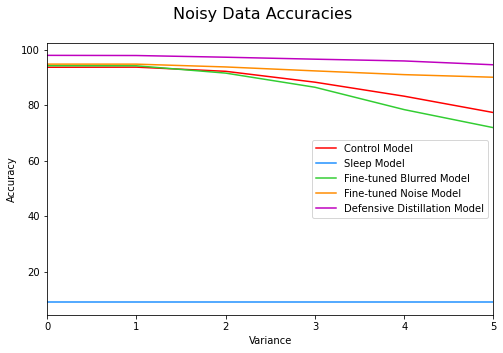

In [27]:
fig = plt.figure(figsize=(8,5))
fig.suptitle('Noisy Data Accuracies', fontsize=16)
ax = fig.add_subplot(111)
ax.plot([i*100 for i in noise_control], color="red", label="Control Model")
ax.plot([i*100 for i in noise_sleep], color='dodgerblue', label="Sleep Model")
ax.plot([i*100 for i in noise_ftblur], color="limegreen", label="Fine-tuned Blurred Model")
ax.plot([i*100 for i in noise_ftnoise], color="darkorange", label="Fine-tuned Noise Model")
ax.plot([i*100 for i in noise_defdist], color='m', label="Defensive Distillation Model")
ax.set_xlabel("Variance")
ax.set_ylabel("Accuracy")
ax.set_xlim(xmin=0.0, xmax=5)
#ax.legend(loc="upper right", bbox_to_anchor=(1.4, 1))
ax.legend()

# **FGSM**

In [28]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

#lists containing test accuracies
fgsm_control = []
fgsm_sleep = []
fgsm_ftblur = []
fgsm_ftnoise = []
fgsm_defdist = []

In [29]:
for eps in epsilons:
  #FGSM
  trainset = MNIST(".", train=True, download=True, transform=transform)
  testset = MNIST(".", train=False, download=True, transform=transform)
  trainset.data = trainset.data[0:27105]
  trainset.targets = trainset.targets[0:27105]

  trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
  testloader = DataLoader(testset, batch_size=128, shuffle=True)

  trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
  testloader = DataLoader(testset, batch_size=128, shuffle=True)

  #FGSM on the baseline model
  #model = torch.load('save_ann.pkl') #baseline
  model = BaselineModel(784, 1200, 10)
  model.load_state_dict(torch.load('Models/fine_tune.pt', map_location=torch.device('cpu'))) #baseline
  model.eval()
  loss_function = nn.CrossEntropyLoss()
  correct = 0.0
  total = 0.0
  for data in testloader:
    inputs, labels = data
    inputs = fgsm(model.to(device), loss_function, inputs, labels, eps).to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    max_prob = torch.argmax(outputs, dim=1)
    temp = max_prob == labels
    correct += len([i for i in temp if i == True])
    total += len(labels)

  acc = correct/total
  print("Accuracy of the testset: ", acc)
  fgsm_control.append(acc)

  #FGSM on the sleep network
  #model = torch.load('save_sleep.pkl') #sleep
  model = FineTuneModel(784, 1200, 10)
  #model = BaselineModel(784, 1200, 10)
  model.load_state_dict(torch.load('Models/snn_model.pt', map_location=torch.device('cpu'))) #sleep
  W1 = torch.clone(model.fc1.weight.data).to(device)
  W2 = torch.clone(model.fc2.weight.data).to(device)
  W3 = torch.clone(model.fc3.weight.data).to(device)

  model.fc1.weight = torch.nn.Parameter(W1/2.19)
  model.fc2.weight = torch.nn.Parameter(W2/2.19)
  model.fc3.weight = torch.nn.Parameter(W3/2.19)
  model.eval()
  loss_function = nn.CrossEntropyLoss()
  correct = 0.0
  total = 0.0
  for data in testloader:
    inputs, labels = data
    inputs = fgsm(model.to(device), loss_function, inputs, labels, eps).to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    max_prob = torch.argmax(outputs, dim=1)
    temp = max_prob == labels
    correct += len([i for i in temp if i == True])
    total += len(labels)

  acc = correct/total
  print("Accuracy of the testset: ", acc)
  fgsm_sleep.append(acc)

  #FGSM on the finetuned network with blur
  #model = torch.load('save_blur.pkl') #blur
  model = FineTuneModel(784, 1200, 10)
  model.load_state_dict(torch.load('Models/blur_model.pt', map_location=torch.device('cpu'))) #blur
  model.eval()
  loss_function = nn.CrossEntropyLoss()
  correct = 0.0
  total = 0.0
  for data in testloader:
    inputs, labels = data
    inputs = fgsm(model.to(device), loss_function, inputs, labels, eps).to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    max_prob = torch.argmax(outputs, dim=1)
    temp = max_prob == labels
    correct += len([i for i in temp if i == True])
    total += len(labels)

  acc = correct/total
  print("Accuracy of the testset: ", acc)
  fgsm_ftblur.append(acc)

  #FGSM on the finetuned network with noise
  #model = torch.load('save_blur.pkl') #noise
  model = FineTuneModel(784, 1200, 10)
  model.load_state_dict(torch.load('Models/noise_model.pt', map_location=torch.device('cpu'))) #noise
  model.eval()
  loss_function = nn.CrossEntropyLoss()
  correct = 0.0
  total = 0.0
  for data in testloader:
    inputs, labels = data
    inputs = fgsm(model.to(device), loss_function, inputs, labels, eps).to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    max_prob = torch.argmax(outputs, dim=1)
    temp = max_prob == labels
    correct += len([i for i in temp if i == True])
    total += len(labels)

  acc = correct/total
  print("Accuracy of the testset: ", acc)
  fgsm_ftnoise.append(acc)

  #FGSM on the defensive distillation network
  #model = torch.load('save_blur.pkl') #def. dist.
  model = DistillationNetwork()
  model.load_state_dict(torch.load('Models/def_distil_model.pt', map_location=torch.device('cpu'))) #def. dist.
  model.eval()
  loss_function = nn.CrossEntropyLoss()
  correct = 0.0
  total = 0.0
  for data in testloader:
    inputs, labels = data
    inputs = fgsm(model.to(device), loss_function, inputs, labels, eps).to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    max_prob = torch.argmax(outputs, dim=1)
    temp = max_prob == labels
    correct += len([i for i in temp if i == True])
    total += len(labels)

  acc = correct/total
  print("Accuracy of the testset: ", acc)
  fgsm_defdist.append(acc)

Accuracy of the testset:  0.9385
Accuracy of the testset:  0.0892
Accuracy of the testset:  0.945
Accuracy of the testset:  0.9491
Accuracy of the testset:  0.9799
Accuracy of the testset:  0.7736
Accuracy of the testset:  0.0893
Accuracy of the testset:  0.7629
Accuracy of the testset:  0.8082
Accuracy of the testset:  0.9517
Accuracy of the testset:  0.4065
Accuracy of the testset:  0.0893
Accuracy of the testset:  0.3707
Accuracy of the testset:  0.5002
Accuracy of the testset:  0.8977
Accuracy of the testset:  0.1194
Accuracy of the testset:  0.0893
Accuracy of the testset:  0.1158
Accuracy of the testset:  0.1797
Accuracy of the testset:  0.7873
Accuracy of the testset:  0.024
Accuracy of the testset:  0.0893
Accuracy of the testset:  0.0278
Accuracy of the testset:  0.0378
Accuracy of the testset:  0.5911
Accuracy of the testset:  0.0041
Accuracy of the testset:  0.0894
Accuracy of the testset:  0.006
Accuracy of the testset:  0.007
Accuracy of the testset:  0.3318
Accuracy of th

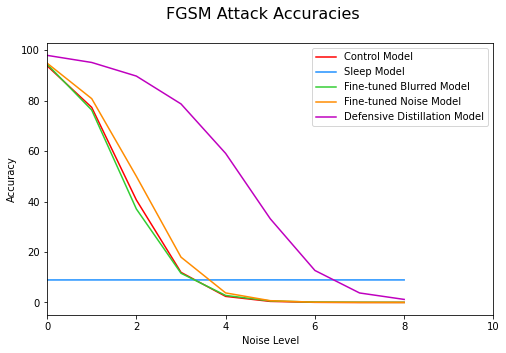

In [30]:
fig = plt.figure(figsize=(8,5))
fig.suptitle('FGSM Attack Accuracies', fontsize=16)
ax = fig.add_subplot(111)
ax.plot([i*100 for i in fgsm_control], color="red", label="Control Model")
ax.plot([i*100 for i in fgsm_sleep], color='dodgerblue', label="Sleep Model")
ax.plot([i*100 for i in fgsm_ftblur], color="limegreen", label="Fine-tuned Blurred Model")
ax.plot([i*100 for i in fgsm_ftnoise], color="darkorange", label="Fine-tuned Noise Model")
ax.plot([i*100 for i in fgsm_defdist], color='m', label="Defensive Distillation Model")
ax.set_xlabel("Noise Level")
ax.set_ylabel("Accuracy")
ax.set_xlim(xmin=0.0, xmax=10)
#ax.legend(loc="upper right", bbox_to_anchor=(1.4, 1))
ax.legend()